In [2]:
import sys
import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models, FoVBackgroundModel, Model
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7fd080c8d3a0>)

## Create dataset

In [4]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1/60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.1

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / resolution**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = False
dataset_asimov_N.irf_model.parameters["bias"].frozen = False


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

datasets = Datasets(dataset_asimov)
datasets_N = Datasets(dataset_asimov_N)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [5]:
%%time
fitting = 1
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets[0])
    print("saving")
    for i, d in enumerate(datasets):
        path = f'data/5_model.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/5_model.yml'
    datasets[0] = Dataset_load.load_dataset_N(datasets[0], path)        
        
        
   

saving
CPU times: user 37.9 s, sys: 12 s, total: 49.9 s
Wall time: 50 s


In [6]:
%%time
fitting_N = 1
if fitting_N :
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run([datasets_N[0]])
    for i, d in enumerate(datasets_N):
        path = f'data/5_model_nui.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/5_model_nui.yml'
    datasets_N[0] = Dataset_load.load_dataset_N(dataset_N, path)        
    

CPU times: user 7min 59s, sys: 12min 37s, total: 20min 36s
Wall time: 5min 3s


# Stat Profiles

## Stat Profiles for BKG Norm

In [7]:
computing_norm = 1
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [8]:
%%time
if computing_norm :
    parameter = datasets[0].models[1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 2min 41s, sys: 56.8 s, total: 3min 38s
Wall time: 3min 39s


In [9]:
%%time
if computing_norm :
    parameter = datasets_N[0].models[1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile(datasets_N[0], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)

    

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

CPU times: user 2h 36min 14s, sys: 3h 47min 40s, total: 6h 23min 54s
Wall time: 1h 48min 14s


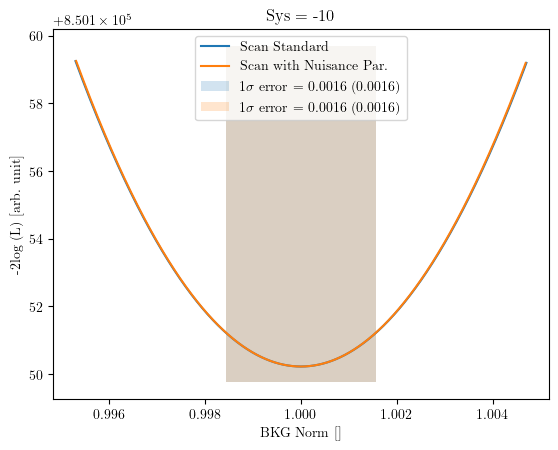

In [10]:
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_norm.png")

## Stat Profiles for Source Signal

In [11]:
%%time
computing_amplitude = 1

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 5min 44s, sys: 1min 59s, total: 7min 43s
Wall time: 7min 44s


In [12]:
%%time
if computing_amplitude:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/

CPU times: user 2h 59min 43s, sys: 4h 31min 50s, total: 7h 31min 33s
Wall time: 2h 2min 22s


In [13]:
print(datasets_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : TQLL36So
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.302   +/-    0.16             
    amplitude                     :   1.00e-12   +/- 6.0e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.016   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    no

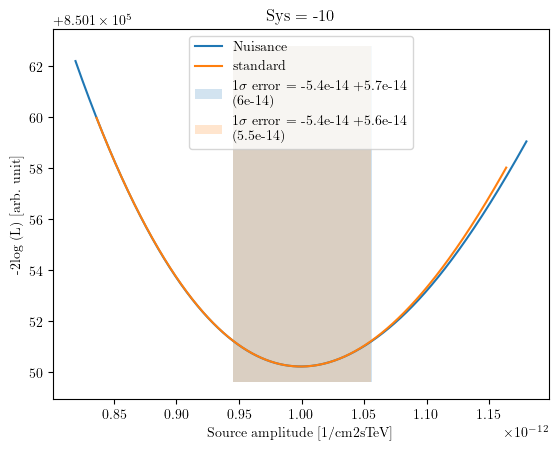

In [14]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})')
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})')

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_amplitude.png")

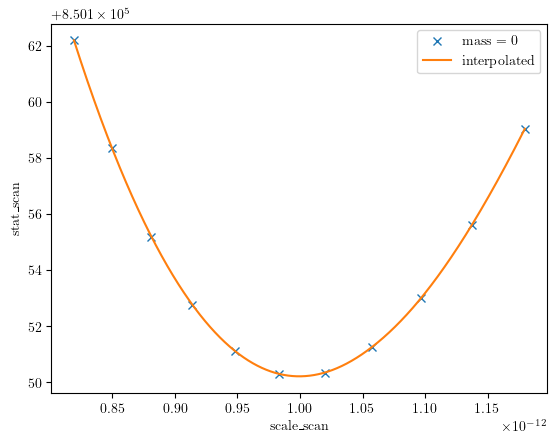

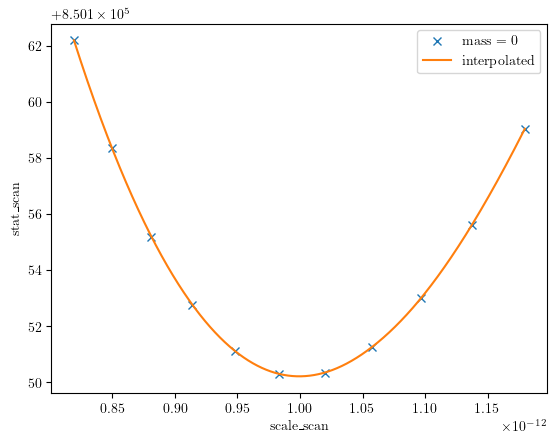

In [15]:
ul_N_a.plot_interpolate()

## Stat Profiles for Source Index

In [16]:
%%time
computing_index = 1

if computing_index:
    sigma = 2
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 4min 30s, sys: 1min 36s, total: 6min 6s
Wall time: 6min 19s


In [17]:
%%time
computing_index_N = 1
if computing_index_N:
    sigma = 2
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/e

CPU times: user 3h 16min 50s, sys: 4h 13min 51s, total: 7h 30min 41s
Wall time: 2h 38min 43s


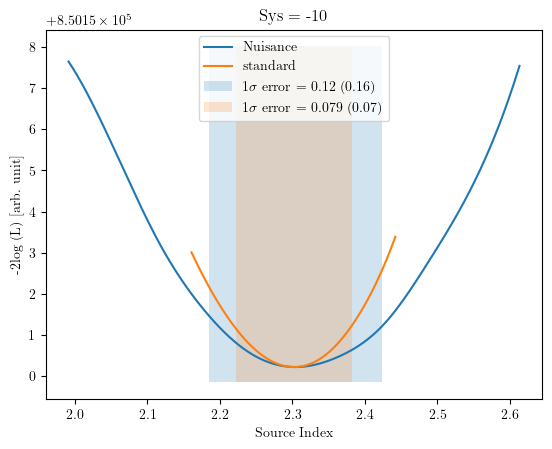

In [18]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_index.png")

### Lambda_

In [20]:
%%time
computing_lambda_ = 1

if computing_lambda_:
    sigma = 2
    parameter_l = datasets[0].models.parameters['lambda_']
    parameter_l.scan_n_sigma = sigma
    stat_profile_l = fit.stat_profile([datasets[0]], parameter_l, reoptimize= True)
    stat_profile_l['scale_scan'] = stat_profile_l.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_lambda_.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_l), file)
    
else:
    with open('data/5_scan_lambda_.yaml') as file:
        stat_profile_l = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 3min 26s, sys: 1min 15s, total: 4min 42s
Wall time: 4min 44s


In [21]:
%%time
computing_lambda__N = 1
if computing_lambda__N:
    sigma = 2
    parameter_l = datasets_N[0].models.parameters['lambda_']
    parameter_l.scan_n_sigma = sigma
    stat_profile_N_l = fit.stat_profile([datasets_N[0]], parameter_l, reoptimize = True)
    stat_profile_N_l['scale_scan'] = stat_profile_N_l.pop(next(iter(stat_profile_N_l)) )    
    
    with open('data/5_scan_lambda__N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_l), file)
    
else:
    with open('data/5_scan_lambda__N.yaml') as file:
        stat_profile_N_l = yaml.load( file, Loader=yaml.FullLoader)

    
    

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anacond

CPU times: user 3h 1min 15s, sys: 4h 14min 52s, total: 7h 16min 7s
Wall time: 2h 11min 57s


KeyError: 'stat_scan'

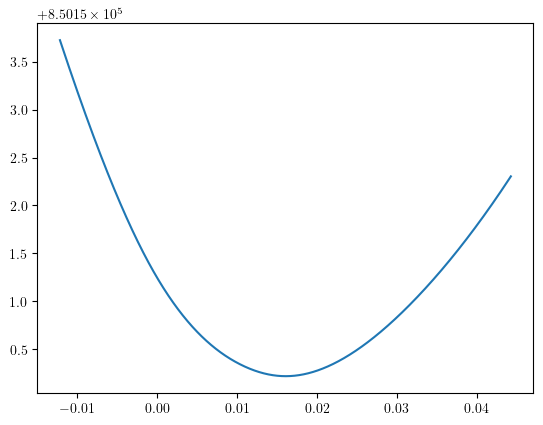

In [22]:
fig = plt.figure()
ll_N_a = stat_profile_N_l.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_l.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

lambda__err = datasets[0].models[0].parameters['lambda_'].error
lambda__err_N = datasets_N[0].models[0].parameters['lambda_'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({lambda__err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({lambda__err:.2})')

plt.xlabel("Source lambda_")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5_stat_scan_lambda_.png")